# Import libraries

In [32]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


tf.__version__
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Found GPU at: /device:GPU:0


In [33]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [34]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/My Projects/Dataset/PlantVillage",
   shuffle = 'True',
   image_size = (IMAGE_SIZE,IMAGE_SIZE),
   batch_size= BATCH_SIZE  
)

Found 2152 files belonging to 3 classes.


In [35]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [36]:
len(dataset)

68

In [37]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

(256, 256, 3)
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0]


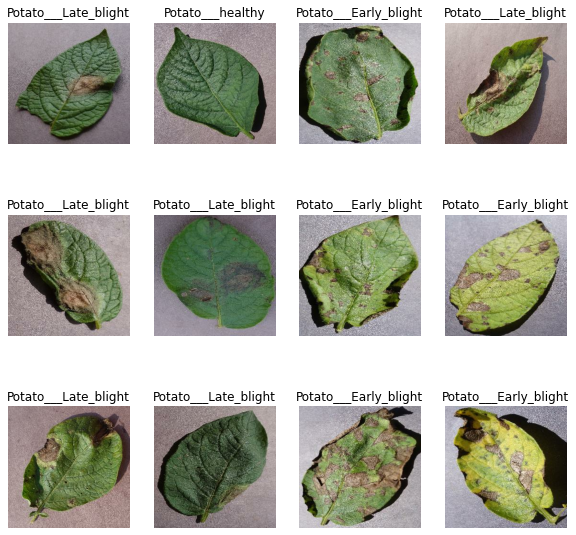

In [38]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")  

# Splitting Dataset

In [39]:
#80% ==> training
#20% ==> 10% validation, 10% test

In [40]:
train_size = 0.8
len(dataset)*train_size 

54.400000000000006

In [41]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [42]:
test_dataset = dataset.skip(54) 
len(test_dataset)

14

In [43]:
val_size=0.1 
len(dataset)*val_size

6.800000000000001

In [44]:
validation_dataset = test_dataset.take(6)
len(validation_dataset)

6

In [45]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [46]:
 def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        
        ds_size = len(ds)
        
        if shuffle:
            ds = ds.shuffle(shuffle_size,seed=12)
         
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)
        
        train_dataset = ds.take(train_size)
        
        validation_dataset = ds.skip(train_size).take(val_size)
        test_dataset = ds.skip(train_size).skip(val_size)
        
        return train_dataset, validation_dataset, test_dataset

In [47]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [48]:
len(train_dataset)

54

In [49]:
len(validation_dataset)

6

In [50]:
len(test_dataset)

8

# Data Preprocessing

In [51]:
train_datatest = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [53]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Building CNN 

In [54]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
]) 

model.build(input_shape=input_shape)

In [55]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [56]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [26]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset
)

Epoch 1/20
54/54 [==============================] - 630s 228ms/step - loss: 0.9312 - accuracy: 0.4853 - val_loss: 0.9034 - val_accuracy: 0.4427
Epoch 2/20
54/54 [==============================] - 11s 122ms/step - loss: 0.7825 - accuracy: 0.5980 - val_loss: 0.8191 - val_accuracy: 0.7083
Epoch 3/20
54/54 [==============================] - 11s 120ms/step - loss: 0.6035 - accuracy: 0.7447 - val_loss: 0.4578 - val_accuracy: 0.8073
Epoch 4/20
54/54 [==============================] - 11s 123ms/step - loss: 0.4477 - accuracy: 0.8084 - val_loss: 0.3092 - val_accuracy: 0.8854
Epoch 5/20
54/54 [==============================] - 11s 121ms/step - loss: 0.3388 - accuracy: 0.8582 - val_loss: 0.3490 - val_accuracy: 0.8646
Epoch 6/20
54/54 [==============================] - 11s 122ms/step - loss: 0.2805 - accuracy: 0.8883 - val_loss: 0.1599 - val_accuracy: 0.9427
Epoch 7/20
54/54 [==============================] - 11s 122ms/step - loss: 0.1862 - accuracy: 0.9278 - val_loss: 0.1676 - val_accuracy: 0.927

In [27]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 5s 39ms/step - loss: 0.0880 - accuracy: 0.9727


In [28]:
scores

[0.08797214925289154, 0.97265625]

In [29]:
history.params

{'epochs': 20, 'steps': 54, 'verbose': 1}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'lower righ'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper righ'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


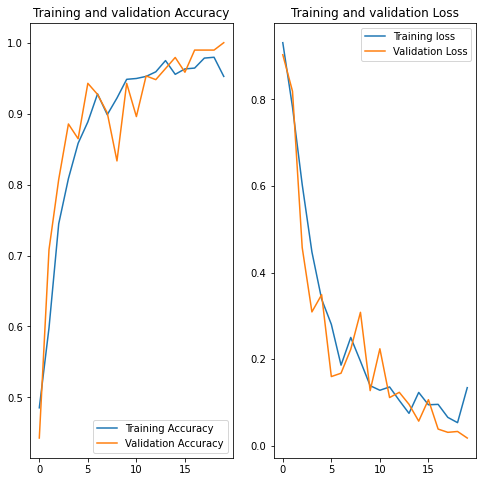

In [57]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower righ')
plt.title('Training and validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper righ')
plt.title('Training and validation Loss')
plt.show()


first image to predict
actual label: Potato___healthy
predicted label: Potato___Late_blight


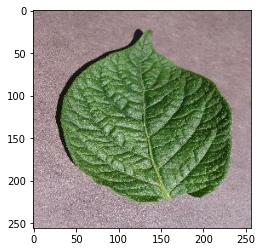

In [58]:

import numpy as np
for images_batch, labels_batch in test_dataset.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

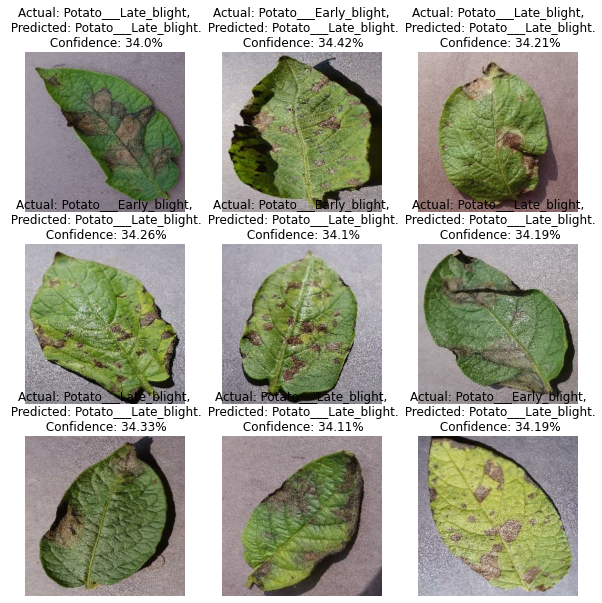

In [61]:
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")